For Prescribed_Burn data 
- Save the raw data to parquet file
- Join w veg data to reduce # of grids
  - Exclude water, agricultural lands, and urban areas based on the vegetation type data.

In [1]:
# Force garbage collection
import gc
gc.collect()

34

In [2]:
# del all variables
import sys
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [3]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [5]:
entity = "Prescribed_Burn"
data_dir = f'../../Extended_Data/{entity}/'
files = os.listdir(data_dir)
files

['calfire_prescribed_burn_1994_2020.cpg',
 'calfire_prescribed_burn_1994_2020.dbf',
 'calfire_prescribed_burn_1994_2020.prj',
 'calfire_prescribed_burn_1994_2020.sbn',
 'calfire_prescribed_burn_1994_2020.sbx',
 'calfire_prescribed_burn_1994_2020.shp',
 'calfire_prescribed_burn_1994_2020.shp.xml',
 'calfire_prescribed_burn_1994_2020.shx']

In [40]:
gdf = gpd.read_file(data_dir)
gdf.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'TREATMENT_', 'TREATMENT1',
       'TREATMEN_1', 'START_DATE', 'END_DATE', 'TREATED_AC', 'GIS_ACRES',
       'RX_CONSUM', 'PRE_CON_CL', 'POST_CON_C', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [41]:
log_messages = []
log_messages.append(f"Task: Data cleaning on {data_dir} with matched weather grid")
log_messages.append(f"Processing started on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# dedup
log_messages.append(f"Initial number of records in the GeoDataFrame: {gdf.shape[0]}")

log_messages.append("=" * 50)
log_messages.append(f"Step0: Dedup on all columns")
gdf = gdf.drop(columns=['TREATMEN_1','TREATMENT_','TREATMENT1','TREATED_AC'], errors='ignore')
gdf = gdf.drop_duplicates()
log_messages.append(f"Number of records after deduplication: {gdf.shape[0]}")

log_messages.append("=" * 50)
log_messages.append(f"Step1: Transform GeoDataFrame to WGS84 (EPSG:4326)")
log_messages.append(f"Current CRS: {gdf.crs}")
gdf_wgs84 = gdf.to_crs('EPSG:4326')
log_messages.append(f"Transformed GeoDataFrame to WGS84 (EPSG:4326)")

In [45]:
log_messages.append("=" * 50)
log_messages.append(f"Step2: Calculate centroids of the geometries and extract latitude and longitude")
gdf_wgs84['centroid'] = gdf_wgs84.centroid
gdf_wgs84['lat'] = gdf_wgs84['centroid'].y
gdf_wgs84['lon'] = gdf_wgs84['centroid'].x

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_26352\678964712.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs84['centroid'] = gdf_wgs84.centroid


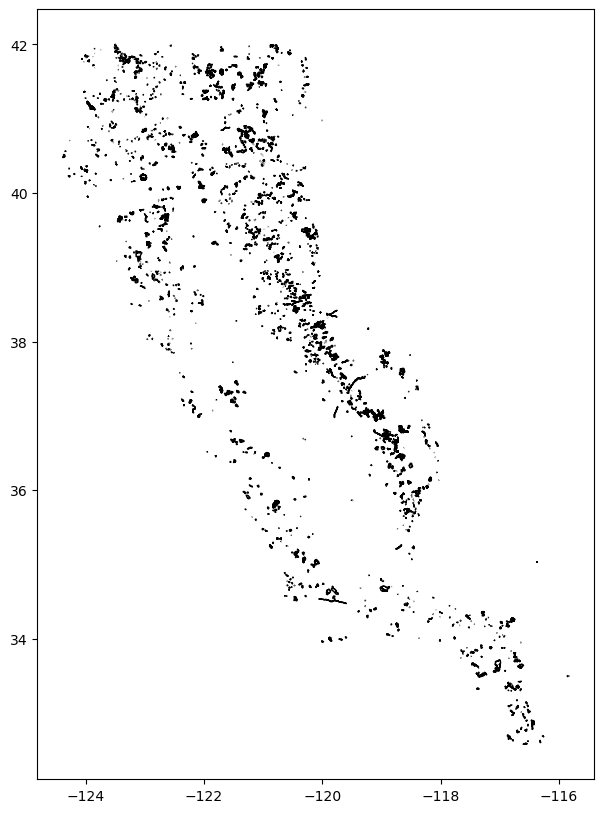

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_wgs84.boundary.plot(ax=ax, linewidth=1, color='black')
plt.show()

## Match w lon/lat in weather data using centroid of burn area

In [46]:
from scipy.spatial import cKDTree
from geopy.distance import geodesic

In [47]:
reference_weather_data = pd.read_parquet('../../Clean_Data/Weather_Data/Extended_Weather_Data/wind_speed.parquet')
reference_weather_data = reference_weather_data[reference_weather_data['day']=='1998-01-01']
reference_weather_data = reference_weather_data[['lon', 'lat']].drop_duplicates()
reference_weather_data.shape

(61404, 2)

In [48]:
gdf_wgs84_small_burn = gdf_wgs84[gdf_wgs84['GIS_ACRES'] <= 4000].reset_index(drop=True)
gdf_wgs84_big_burn = gdf_wgs84[gdf_wgs84['GIS_ACRES'] > 4000].reset_index(drop=True)
# assert error if the shape of small and big burn GeoDataFrames are not equal to the original GeoDataFrame
assert gdf_wgs84_small_burn.shape[0] + gdf_wgs84_big_burn.shape[0] == gdf_wgs84.shape[0], "The sum of small and big burn GeoDataFrames does not match the original GeoDataFrame shape."

In [49]:
log_messages.append("=" * 50)
log_messages.append(f"Step3: Match w weather grid for small burn: Nearest weather grid points found and distances calculated")
log_messages.append(f"Number of records before matching: {gdf_wgs84_small_burn.shape[0]}")
log_messages.append(f"Number of records after matching: {gdf_wgs84_small_burn.shape[0]}")
log_messages.append("For the distance between the matched weather grid points and prescribed burn centroids points, the following statistics were calculated:")

In [50]:
# Create a KDTree for the reference coordinates
tree = cKDTree(reference_weather_data[['lat', 'lon']].values)
approx_distances, indices = tree.query(gdf_wgs84_small_burn[['lat', 'lon']].values, k=1)

In [51]:
# Calculate the exact geodesic distances
exact_distances = []
nearest_lats = []
nearest_lons = []

for i, idx in enumerate(indices):
    coords_1 = (gdf_wgs84_small_burn.iloc[i]['lat'], gdf_wgs84_small_burn.iloc[i]['lon'])
    coords_2 = (reference_weather_data.iloc[idx]['lat'], reference_weather_data.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)
    nearest_lats.append(coords_2[0])
    nearest_lons.append(coords_2[1])

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

# Add the nearest lat, lon, and distance to gdf_wgs84_small_burn
gdf_wgs84_small_burn['NEAREST_LAT'] = nearest_lats
gdf_wgs84_small_burn['NEAREST_LON'] = nearest_lons
gdf_wgs84_small_burn['DISTANCE_KM'] = exact_distances

In [52]:
log_messages.append(f"Min distance: {exact_distances.min():.2f} km")
log_messages.append(f"Max distance: {exact_distances.max():.2f} km")

In [53]:
log_messages.append("=" * 50)
log_messages.append(f"Step4: Match w weather grid for BIG burn (GIS_ACRES>4000)")
log_messages.append(
    "We match each burn area to weather grid points by drawing a slightly larger outline (buffer) around the burn area.\n"
    "The buffer size is set to 0.01 degrees, which is approximately 1.1 km at the equator.\n"
    "and then selecting all weather grids that fall inside this expanded boundary.\n"
    "This helps us include grid that is close enough to be relevant, even if the center of grid is not exactly inside the burn area."
)

In [54]:
gdf_wgs84_big_burn.shape

(20, 16)

In [55]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Convert weather_df to GeoDataFrame
weather_gdf = gpd.GeoDataFrame(
    reference_weather_data,
    geometry=gpd.points_from_xy(reference_weather_data['lon'], reference_weather_data['lat']),
    crs='EPSG:4326'
)

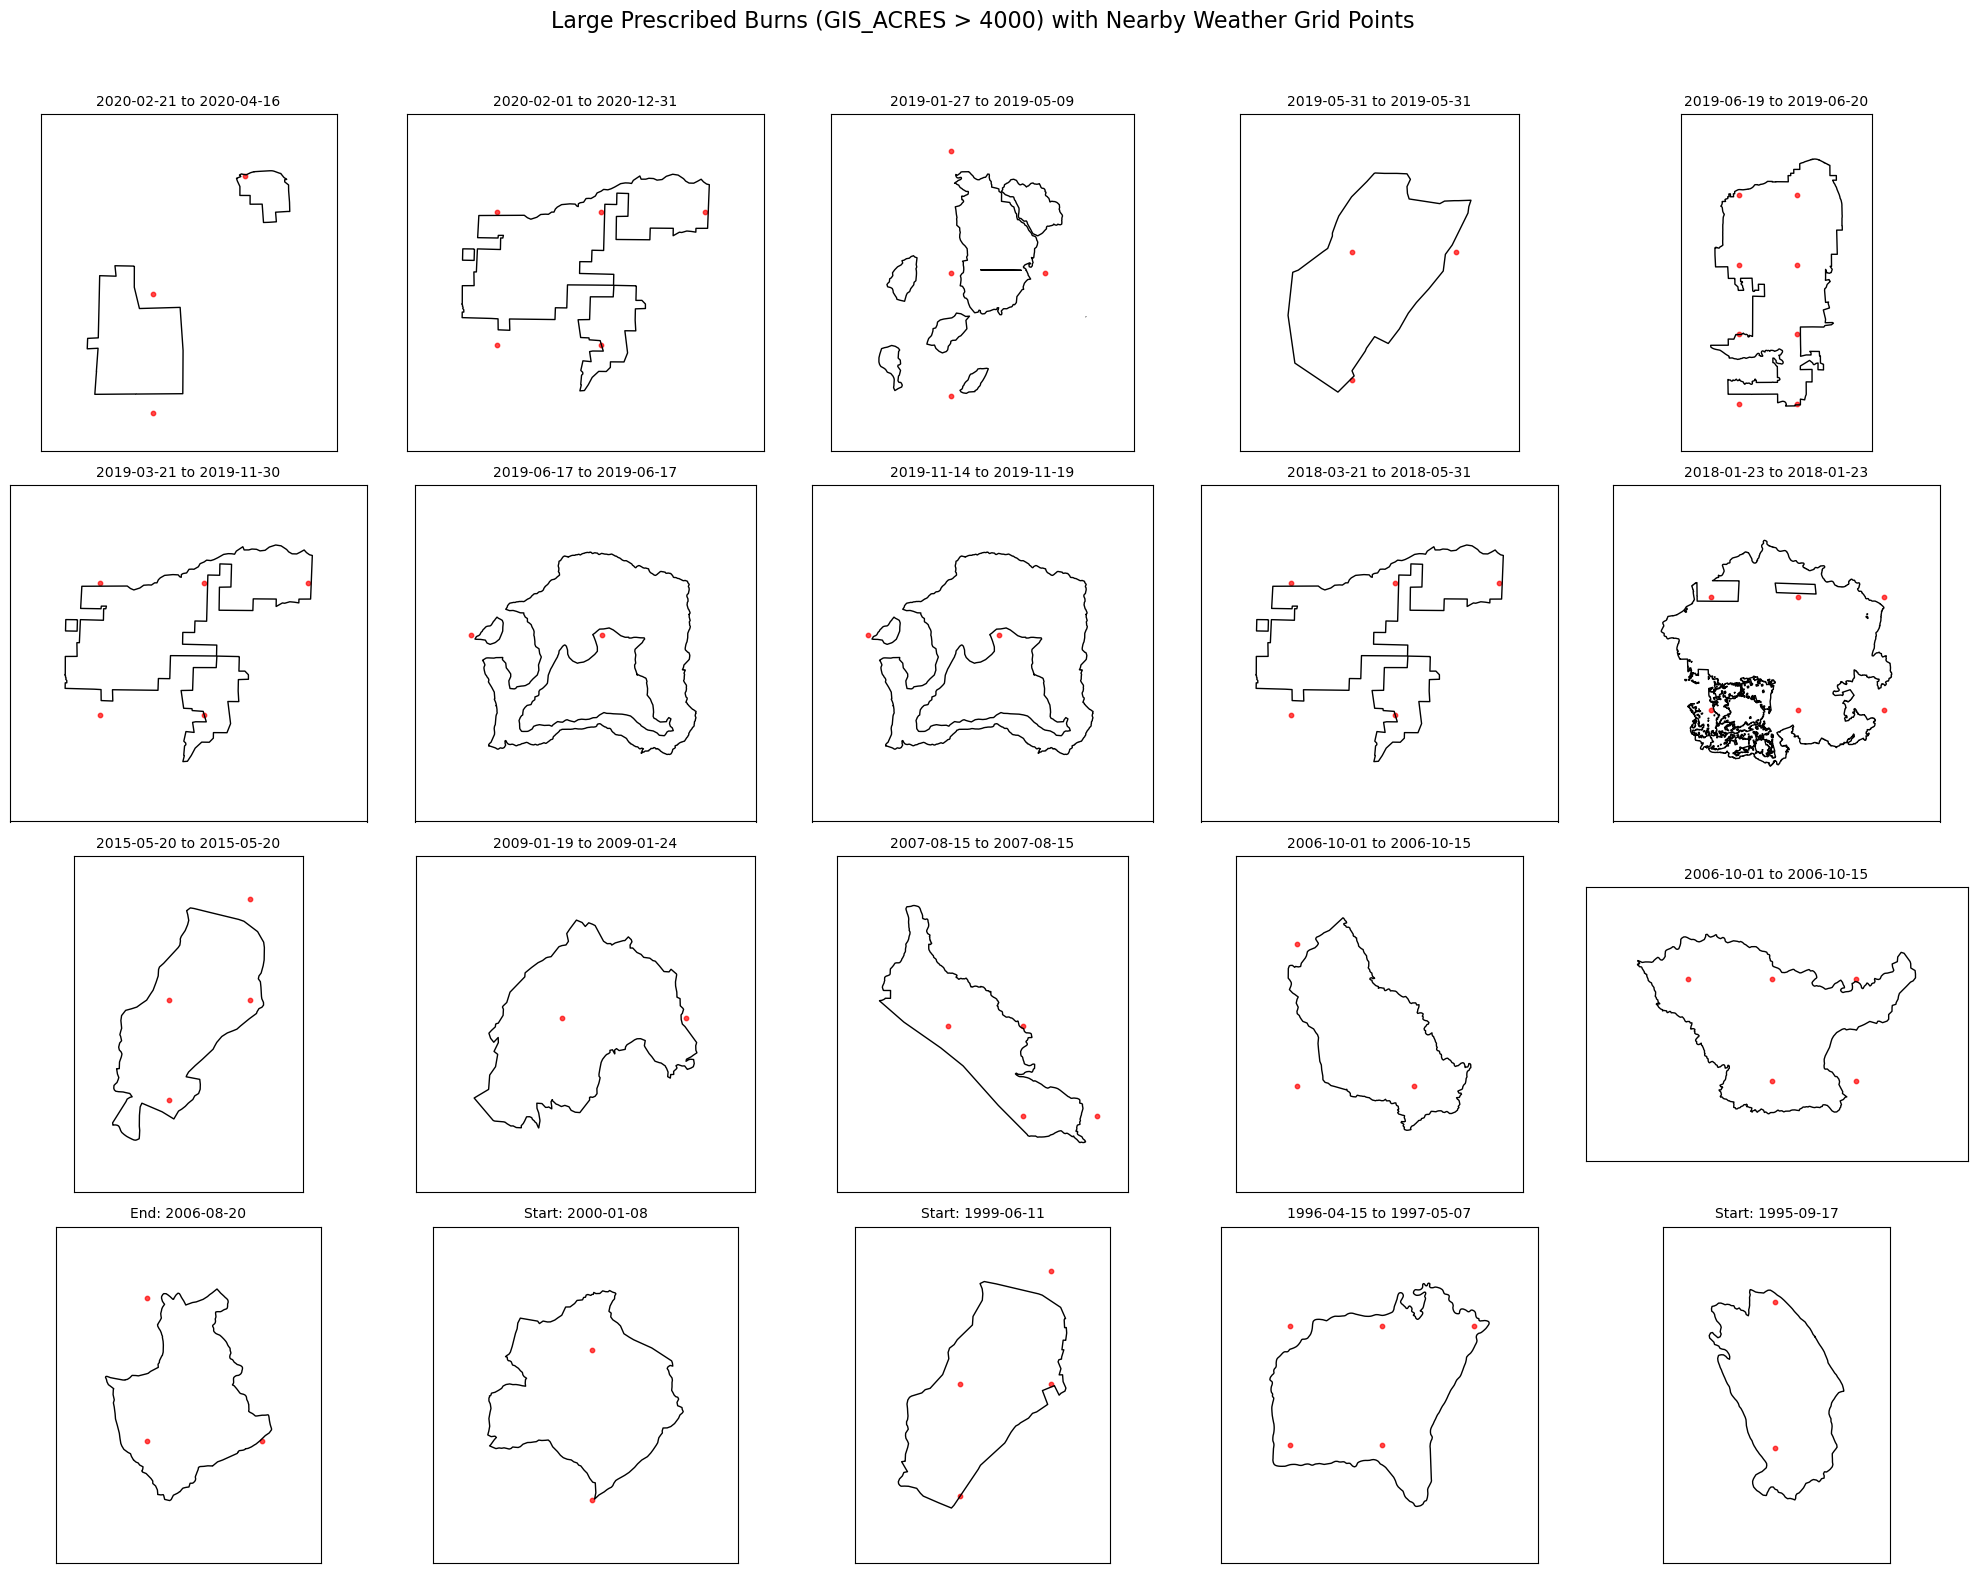

In [56]:
path_to_save_plots = '../../Plot/Prescribed_Burn/'
if not os.path.exists(path_to_save_plots):
    os.makedirs(path_to_save_plots)
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

burn_points_list = []

def format_date(dt):
    if pd.notnull(dt):
        if hasattr(dt, 'strftime'):
            return dt.strftime('%Y-%m-%d')
        else:
            return str(dt)
    return None

for i, (idx, burn_row) in enumerate(gdf_wgs84_big_burn.iterrows()):
    ax = axes[i]
    # Plot the burn boundary
    gpd.GeoSeries([burn_row.geometry]).boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Optionally overlay weather points within/near this burn
    # Buffer the polygon for "nearby" points (adjust buffer as needed)
    buffer_geom = burn_row.geometry.buffer(0.01) 
    points_in_buffer = weather_gdf[weather_gdf.within(buffer_geom)]
    points_in_buffer.plot(ax=ax, color='red', markersize=10, alpha=0.7)
    
    # Save points_in_buffer for this burn
    burn_points_list.append({
        'big_burn_index': idx,
        'points_in_buffer': points_in_buffer.geometry.tolist() # for coordinates
    })

    # Set extent to the polygon (with a small margin)
    minx, miny, maxx, maxy = buffer_geom.bounds
    margin_x = (maxx - minx) * 0.1
    margin_y = (maxy - miny) * 0.1
    ax.set_xlim(minx - margin_x, maxx + margin_x)
    ax.set_ylim(miny - margin_y, maxy + margin_y)
    
    start_date = burn_row.get('START_DATE', None)
    end_date = burn_row.get('END_DATE', None)



    start_str = format_date(start_date)
    end_str = format_date(end_date)

    if start_str and end_str:
        title = f"{start_str} to {end_str}"
    elif start_str:
        title = f"Start: {start_str}"
    elif end_str:
        title = f"End: {end_str}"
    else:
        title = burn_row.get('BURN_NAME', f'Burn {idx+1}')

    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Large Prescribed Burns (GIS_ACRES > 4000) with Nearby Weather Grid Points', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(path_to_save_plots, 'large_burns_with_nearby_weather_grid.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [57]:
log_messages.append(f"Plot saved to {path_to_save_plots}large_burns_with_nearby_weather_grid.png")

In [58]:
burn_points_df = pd.DataFrame(burn_points_list)

# Suppose the column with the list of points is named 'points'
burn_points_long = burn_points_df.explode('points_in_buffer').reset_index(drop=True)

# extract lat and lon from the points
burn_points_long['NEAREST_LAT'] = burn_points_long['points_in_buffer'].apply(lambda p: p.y if isinstance(p, Point) else None)
burn_points_long['NEAREST_LON'] = burn_points_long['points_in_buffer'].apply(lambda p: p.x if isinstance(p, Point) else None)

In [59]:
burn_points_long.groupby('big_burn_index').size().reset_index(name='num_points')

,big_burn_index,num_points
0,0,3
1,1,5
2,2,4
3,3,3
4,4,8
5,5,5
6,6,2
7,7,2
8,8,5
9,9,6


In [60]:
burn_points_long.head(6)

,big_burn_index,points_in_buffer,NEAREST_LAT,NEAREST_LON
0,0,POINT (-122.8499999666667 38.90000000000001),38.900000,-122.850000
1,0,POINT (-122.8499999666667 38.85833333333334),38.858333,-122.850000
2,0,POINT (-122.8083333 38.94166666666667),38.941667,-122.808333
3,1,POINT (-120.4749999666667 38.44166666666667),38.441667,-120.475000
4,1,POINT (-120.4749999666667 38.40000000000001),38.400000,-120.475000
5,1,POINT (-120.4333333 38.44166666666667),38.441667,-120.433333


In [61]:
burn_points_long.shape

(77, 4)

In [62]:
# add col big_burn_index to gdf_wgs84_big_burn
gdf_wgs84_big_burn['big_burn_index'] = gdf_wgs84_big_burn.index
log_messages.append(f"Shape of gdf_wgs84_big_burn: {gdf_wgs84_big_burn.shape}")
# merge burn_points_long with gdf_wgs84_big_burn on big_burn_index
gdf_wgs84_big_burn = gdf_wgs84_big_burn.merge(burn_points_long, on='big_burn_index', how='inner')
log_messages.append(f"Shape of gdf_wgs84_big_burn after merging with burn_points_long: {gdf_wgs84_big_burn.shape}")
log_messages.append(f"The num of record increases bc each burn may have multiple weather grid points associated with it.")

In [63]:
gdf_wgs84_small_burn.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'START_DATE', 'END_DATE',
       'GIS_ACRES', 'RX_CONSUM', 'PRE_CON_CL', 'POST_CON_C', 'Shape_Leng',
       'Shape_Area', 'geometry', 'centroid', 'lat', 'lon', 'NEAREST_LAT',
       'NEAREST_LON', 'DISTANCE_KM'],
      dtype='object')

In [64]:
gdf_wgs84_big_burn.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'START_DATE', 'END_DATE',
       'GIS_ACRES', 'RX_CONSUM', 'PRE_CON_CL', 'POST_CON_C', 'Shape_Leng',
       'Shape_Area', 'geometry', 'centroid', 'lat', 'lon', 'big_burn_index',
       'points_in_buffer', 'NEAREST_LAT', 'NEAREST_LON'],
      dtype='object')

In [65]:
cols_to_keep = ['YEAR_', 'START_DATE', 'END_DATE', 'GIS_ACRES', 'geometry', 'centroid', 'lat', 'lon', 'NEAREST_LAT', 'NEAREST_LON']
gdf_wgs84_small_burn = gdf_wgs84_small_burn[cols_to_keep]
gdf_wgs84_big_burn = gdf_wgs84_big_burn[cols_to_keep]
gdf_wgs84 = pd.concat([gdf_wgs84_small_burn, gdf_wgs84_big_burn], ignore_index=True)

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_15824\3887932158.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf_buffered.geometry.buffer(buffer_dist)


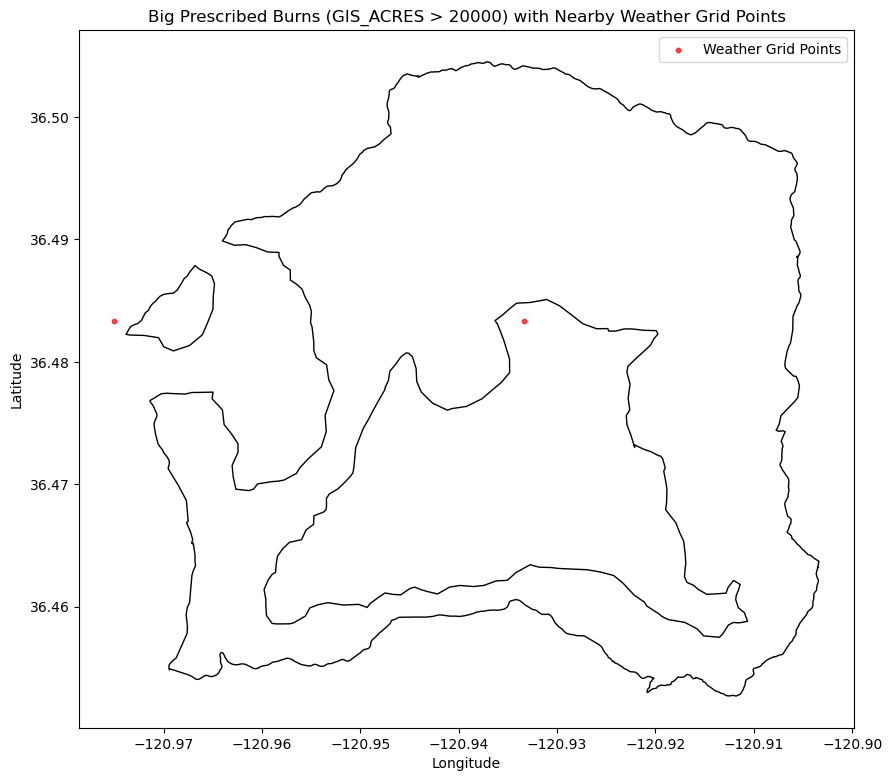

In [ ]:
# # example on one plot
# buffer_dist = 0.01  # ~10km, adjust as needed
# # get 6th data from gdf_wgs84_big_burn
# gdf_wgs84_big_burn_7th = gdf_wgs84_big_burn.iloc[6:7].reset_index(drop=True)
# gdf_buffered = gdf_wgs84_big_burn_7th.copy()
# gdf_buffered['geometry'] = gdf_buffered.geometry.buffer(buffer_dist)

# # Points within or near the boundaries
# weather_near_burn = gpd.sjoin(weather_gdf, gdf_buffered, how='inner', predicate='intersects')

# # Step 3: Plot
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_wgs84_big_burn_7th.boundary.plot(ax=ax, linewidth=1, color='black')
# weather_near_burn.plot(ax=ax, color='red', markersize=10, alpha=0.7, label='Weather Grid Points')
# plt.title('Big Prescribed Burns (GIS_ACRES > 20000) with Nearby Weather Grid Points')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend()
# plt.show()
# plt.close()

In [66]:
log_messages.append("=" * 50)
log_messages.append(f"Step5: Check for NaT values in START_DATE and END_DATE")
no_clear_date_record = gdf_wgs84[(gdf_wgs84['START_DATE'].isna()) & (gdf_wgs84['END_DATE'].isna())]
one_date_record =gdf_wgs84[
    (gdf_wgs84['START_DATE'].isna() ^ gdf_wgs84['END_DATE'].isna())
]
clear_record_with_both_dates = gdf_wgs84[
    (gdf_wgs84['START_DATE'].notna()) & (gdf_wgs84['END_DATE'].notna())
]
# check if sum of the three conditions equals the total number of rows
assert (no_clear_date_record.shape[0] + one_date_record.shape[0] + clear_record_with_both_dates.shape[0]) == gdf_wgs84.shape[0]
log_messages.append(f"Found {no_clear_date_record.shape[0]} records with both START_DATE and END_DATE as NaT")
log_messages.append(f"Found {one_date_record.shape[0]} records with one of START_DATE or END_DATE as NaT")
log_messages.append(f"Found {clear_record_with_both_dates.shape[0]} records with both START_DATE and END_DATE available")



log_messages.append("=" * 50)
log_messages.append(f"Step6: Save the {entity} record which has no clear date record")
log_messages.append(
    "This file will be used for further filtering. Grids with documented prescribed burns will be removed from the model data for the entire burn year, as the exact burn dates are unknown."
)
no_clear_date_record = no_clear_date_record[['YEAR_', 'NEAREST_LAT', 'NEAREST_LON']]
path_to_save = f'../../Clean_Data/Extended_Data/{entity}/'
file_name = f'{entity}_no_clear_date_record.parquet'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
no_clear_date_record.to_parquet(f'{path_to_save}/{file_name}')


log_messages.append("=" * 50)
log_messages.append(f"Step7: Fill NaT values in START_DATE and END_DATE")
log_messages.append(f"Filling NaT values in START_DATE with END_DATE and vice versa")
# log the current shape of the GeoDataFrame
log_messages.append(f"Shape of the GeoDataFrame: {gdf_wgs84.shape}")
gdf_wgs84['START_DATE'] = gdf_wgs84['START_DATE'].fillna(gdf_wgs84['END_DATE'])
gdf_wgs84['END_DATE'] = gdf_wgs84['END_DATE'].fillna(gdf_wgs84['START_DATE'])
gdf_wgs84 = gdf_wgs84.dropna(subset=['START_DATE', 'END_DATE'])
log_messages.append(
    f"GeoDataFrame shape after filling NaT values and dropping rows where both date columns are missing: {gdf_wgs84.shape}"
)

## Analysis

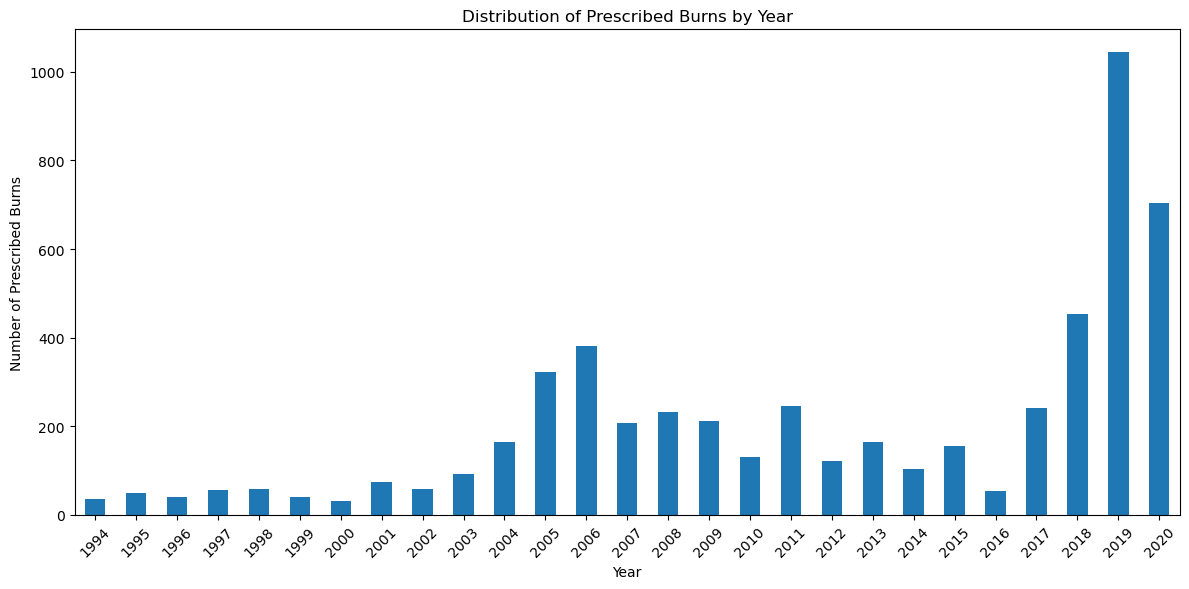

In [67]:
# plot the distribution of YEAR_
gdf_wgs84['YEAR_'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Prescribed Burns by Year')
plt.xlabel('Year')
plt.ylabel('Number of Prescribed Burns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

## Clean to Boolean

In [ ]:
# check missing values in the GeoDataFrame
gdf_wgs84.isnull().sum()

YEAR_          0
START_DATE     0
END_DATE       0
GIS_ACRES      0
geometry       0
centroid       0
lat            0
lon            0
NEAREST_LAT    0
NEAREST_LON    0
dtype: int64

In [94]:
log_messages.append("=" * 50)
log_messages.append(f"Step8: Dedup based on START_DATE, END_DATE, NEAREST_LAT, and NEAREST_LON")

cols_to_dup = ['START_DATE', 'END_DATE','NEAREST_LAT','NEAREST_LON']
gdf_wgs84 = gdf_wgs84[cols_to_dup]
log_messages.append(f"Shape of the GeoDataFrame before dropping duplicates: {gdf_wgs84.shape}")
gdf_wgs84 = gdf_wgs84.drop_duplicates().reset_index(drop=True)
log_messages.append(f"Shape of the GeoDataFrame after dropping duplicates: {gdf_wgs84.shape}")

In [95]:
log_messages

['Task: Data cleaning on ../../Extended_Data/Prescribed_Burn/ with matched weather grid',
 'Processing started on: 2025-06-14 19:21:13',
 'Initial number of records in the GeoDataFrame: 5892',
 '==================================================',
 'Step0: Dedup on all columns',
 'Number of records after deduplication: 5685',
 '==================================================',
 'Step1: Transform GeoDataFrame to WGS84 (EPSG:4326)',
 'Current CRS: EPSG:3310',
 'Transformed GeoDataFrame to WGS84 (EPSG:4326)',
 '==================================================',
 'Step2: Calculate centroids of the geometries and extract latitude and longitude',
 '==================================================',
 'Step3: Match w weather grid for small burn: Nearest weather grid points found and distances calculated',
 'Number of records before matching: 5665',
 'Number of records after matching: 5665',
 'For the distance between the matched weather grid points and prescribed burn centroids points, 

In [96]:
gdf_wgs84.head(3)

,START_DATE,END_DATE,NEAREST_LAT,NEAREST_LON
0,2020-01-31,2020-01-31,38.733333,-120.516667
1,2020-02-13,2020-02-13,38.900000,-120.641667
2,2020-02-13,2020-02-18,38.483333,-120.558333


In [99]:
# assign START_DATE and END_DATE as datetime
gdf_wgs84['START_DATE'] = pd.to_datetime(gdf_wgs84['START_DATE'], errors='coerce')
gdf_wgs84['END_DATE'] = pd.to_datetime(gdf_wgs84['END_DATE'], errors='coerce')

In [100]:
gdf_wgs84.head(3)

,START_DATE,END_DATE,NEAREST_LAT,NEAREST_LON
0,2020-01-31,2020-01-31,38.733333,-120.516667
1,2020-02-13,2020-02-13,38.900000,-120.641667
2,2020-02-13,2020-02-18,38.483333,-120.558333


In [107]:
# add days difference column
gdf_wgs84['DAYS_DIFF'] = (gdf_wgs84['END_DATE'] - gdf_wgs84['START_DATE']).dt.days
# check max and min days difference
log_messages.append(f"Max days difference: {gdf_wgs84['DAYS_DIFF'].max()}")
log_messages.append(f"Min days difference: {gdf_wgs84['DAYS_DIFF'].min()}")

In [109]:
gdf_wgs84_check = gdf_wgs84[gdf_wgs84['DAYS_DIFF'] > 300]

In [110]:
gdf_wgs84_check

,START_DATE,END_DATE,NEAREST_LAT,NEAREST_LON,DAYS_DIFF
119,2019-02-01,2020-02-05,39.358333,-122.600000,369
123,2019-05-01,2020-06-05,34.233333,-116.975000,401
133,2008-03-04,2020-02-04,35.816667,-118.475000,4354
144,2018-09-16,2020-06-01,39.108333,-120.766667,624
151,2018-09-16,2020-06-01,39.108333,-120.725000,624
...,...,...,...,...,...
4055,1996-04-15,1997-05-07,39.191667,-123.141667,387
4056,1996-04-15,1997-05-07,39.150000,-123.141667,387
4057,1996-04-15,1997-05-07,39.191667,-123.100000,387
4058,1996-04-15,1997-05-07,39.150000,-123.100000,387


In [128]:
gdf = gpd.read_file(data_dir)
gdf = gdf.drop(columns=['TREATMEN_1','TREATMENT_','TREATMENT1','TREATED_AC'], errors='ignore')
gdf = gdf.drop_duplicates()
# only keep rows where START_DATE and END_DATE are not NaT
gdf = gdf[gdf['START_DATE'].notna() & gdf['END_DATE'].notna()]
gdf.shape
gdf['START_DATE'] = pd.to_datetime(gdf['START_DATE'], errors='coerce')
gdf['END_DATE'] = pd.to_datetime(gdf['END_DATE'], errors='coerce')
gdf['DAYS_DIFF'] = (gdf['END_DATE'] - gdf['START_DATE']).dt.days

In [130]:
gdf.shape

(4006, 14)

In [138]:
# check # and % of rows with DAYS_DIFF > 300
num_rows_days_diff_gt_300 = gdf[gdf['DAYS_DIFF'] > 14].shape[0]
total_rows = gdf.shape[0]
percent_rows_days_diff_gt_300 = (num_rows_days_diff_gt_300 / total_rows) * 100
print(f"Number of rows with DAYS_DIFF > 300: {num_rows_days_diff_gt_300}")
print(f"Percentage of rows with DAYS_DIFF > 300: {percent_rows_days_diff_gt_300:.2f}%")

Number of rows with DAYS_DIFF > 300: 1061
Percentage of rows with DAYS_DIFF > 300: 26.49%


In [137]:
215/4006

0.053669495756365454

In [132]:
gdf_check = gdf[gdf['DAYS_DIFF'] > 300]

In [133]:
gdf_check.shape

(215, 14)

In [120]:
gdf_check.head(3)

,YEAR_,STATE,AGENCY,UNIT_ID,TREATMENT_,TREATMENT1,TREATMEN_1,START_DATE,END_DATE,TREATED_AC,GIS_ACRES,RX_CONSUM,PRE_CON_CL,POST_CON_C,Shape_Leng,Shape_Area,geometry,DAYS_DIFF
80,2020,CA,CDF,TCU,9655,2020-Winton Broadcast Burn,1,2020-02-01,2020-12-31,123.08,6311.960,0,0,0,50593.423878,2.554358e+07,"MULTIPOLYGON (((-34883.798 48498.085, -34822.8...",334
146,2020,CA,USF,MNF,0330002000,MINE CAMP DIVERSION DAM,1,2019-02-01,2020-02-05,178.00,119.737,0,0,0,8668.916432,4.845577e+05,"MULTIPOLYGON (((-225155.355 154322.271, -22512...",369
155,2020,CA,USF,BDF,330340F000,BLUFF MESA,1,2019-05-01,2020-06-05,108.00,107.725,0,0,0,3408.966502,4.359462e+05,"POLYGON ((278510.630 -416705.295, 278510.975 -...",401


In [111]:
gdf = gpd.read_file(data_dir)

In [112]:
# drop na in START_DATE and END_DATE
gdf = gdf.dropna(subset=['START_DATE', 'END_DATE'])

In [108]:
log_messages

['Task: Data cleaning on ../../Extended_Data/Prescribed_Burn/ with matched weather grid',
 'Processing started on: 2025-06-14 19:21:13',
 'Initial number of records in the GeoDataFrame: 5892',
 '==================================================',
 'Step0: Dedup on all columns',
 'Number of records after deduplication: 5685',
 '==================================================',
 'Step1: Transform GeoDataFrame to WGS84 (EPSG:4326)',
 'Current CRS: EPSG:3310',
 'Transformed GeoDataFrame to WGS84 (EPSG:4326)',
 '==================================================',
 'Step2: Calculate centroids of the geometries and extract latitude and longitude',
 '==================================================',
 'Step3: Match w weather grid for small burn: Nearest weather grid points found and distances calculated',
 'Number of records before matching: 5665',
 'Number of records after matching: 5665',
 'For the distance between the matched weather grid points and prescribed burn centroids points, 

In [101]:
# Function to expand each row
def expand_dates(row):
    start_date = row['START_DATE']
    end_date = row['END_DATE']
    date_range = pd.date_range(start=start_date, end=end_date)
    return pd.DataFrame({
        'lon': row['NEAREST_LON'],
        'lat': row['NEAREST_LAT'],
        'DATE': date_range
    })

# Apply the function to each row and concatenate the results
expanded_burn_data = pd.concat(gdf_wgs84.apply(expand_dates, axis=1).to_list(), ignore_index=True)

In [102]:
log_messages.append("=" * 50)
log_messages.append(f"Step9: Expand the GeoDataFrame to daily records")
log_messages.append(f"Shape of the GeoDataFrame after expanding: {expanded_burn_data.shape}")

In [ ]:
# add column IS_PRESCRIBED_BURN
expanded_burn_data['IS_PRESCRIBED_BURN'] = 1

In [ ]:
# check if expanded_burn_data is unique, if not, raise an error
if not expanded_burn_data.duplicated().sum() == 0:
    raise ValueError("The expanded_burn_data contains duplicate records. Please check the data.")

In [ ]:
# path_to_save = f'../../Clean_Data/Extended_Data/{entity}'
# file_name = f'{entity}_expanded_burn_data_by_lon_lat_day.parquet'
# # Ensure the output directory exists
# if not os.path.exists(path_to_save):
#     os.makedirs(path_to_save)

# expanded_burn_data.to_parquet(f'{path_to_save}/{file_name}', index=False)
# log_messages.append(f"Expanded burn data saved to {path_to_save}/{file_name}")

In [106]:
expanded_burn_data.shape

(252440, 3)

In [ ]:
gdf = gpd.read_file(data_dir)

In [105]:
expanded_burn_data

,lon,lat,DATE
0,-120.516667,38.733333,2020-01-31
1,-120.641667,38.900000,2020-02-13
2,-120.558333,38.483333,2020-02-13
3,-120.558333,38.483333,2020-02-14
4,-120.558333,38.483333,2020-02-15
...,...,...,...
252435,-123.058333,39.191667,1997-05-05
252436,-123.058333,39.191667,1997-05-06
252437,-123.058333,39.191667,1997-05-07
252438,-120.725000,38.191667,1995-09-17
